# Setup

- Import necessary packages
- Load data

In [6]:
import numpy as np
import pandas as pd
import os
import tokenizers
import string
import torch
import seaborn as sns
import transformers
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import re

/data/nithish/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Data Visualization

In [3]:
train.shape

(27481, 4)

In [4]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [10]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


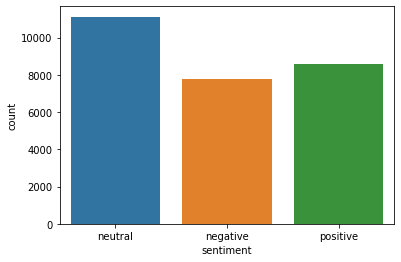

In [7]:
_ = sns.countplot(train.sentiment)

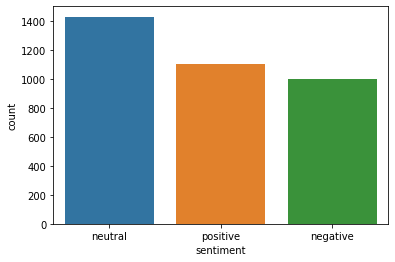

In [8]:
_ = sns.countplot(test.sentiment)

Question 1: For neutral sentiment tweets, are text and selected text columns same?

In [16]:
neutral = train[train.sentiment=='neutral']

In [18]:
len(neutral), sum(neutral.text == neutral.selected_text)

(11118, 5930)

Around half of the tweets with sentiment = 'neutral' are same

Let's look at neutral tweets where text != selected_text

In [25]:
pd.set_option('display.max_colwidth', -1)  # to display all the text

In [26]:
neutral[neutral.text != neutral.selected_text].sample(n=10)
# randomly pick 10 rows

,textID,text,selected_text,sentiment
199,7a718b23ef,_Sanderson What`s with Twatter lately? Either I can`t get on or the replies don`t turn up!,What`s with Twatter lately? Either I can`t get on or the replies don`t turn up!,neutral
19458,7dad90e273,"I spoke too soon Still a nice evening, but lots of broken cloud coming in from the south.","I spoke too soon Still a nice evening, but lots of broken cloud coming in from the south.",neutral
26472,68a56eca92,"..uuuups today is mother day???....sh***....iï¿½ve forgot it, my work doesnï¿½t have a end *sigh*....thank you for remind it","..uuuups today is mother day???....sh***....iï¿½ve forgot it, my work doesnï¿½t have a end *sigh*....thank you for remind it",neutral
2931,b1e3728694,I hope when you`re calling this the shitshow you mean that in a good way. because this will be fun.,e when you`re calling this the shitshow you mean that in a good way. because this will be fun.,neutral
12905,20486c94d2,why!!!! u have to bring it to you 24/7 like the _team,why!!!! u have to bring it to you 24/7 like the _team,neutral
22492,9954cca530,my *mom*(not aunt haha) and uncle were both adopted with very diff adoptive stories. if you want to chat sometime lmk,my *mom*(not aunt haha) and uncle were both adopted with very diff adoptive stories. if you want to chat sometime lmk,neutral
15505,f62728e9d7,"well, someone told me it`s only there for two weeks i`m going again next week with a friend IN SCHOOL TIME :p ...","well, someone told me it`s only there for two weeks i`m going again next week with a friend IN SCHOOL TIME :p ..",neutral
16951,a181702898,i can`t call you cause my portable sais that this number not excist i want so much to talk to you,i can`t call you cause my portable sais that this number not excist i want so much to talk to you,neutral
11173,4d3e3aeb24,You really think it was that awesome? We`ll have to discuss,You really think it was that awesome? We`ll have to discuss,neutral
8964,4eab36d2d2,tea... Mmmm crispy but no cake Have headphones!,tea... Mmmm crispy but no cake Have headphones!,neutral


These tweets look similar.
Are there trailing spaces or space at the beginning of strings?

In [32]:
row = neutral.loc[19458,:]

In [34]:
row.text.strip() == row.selected_text.strip()

True

We need to remove these leading and trailing spaces. Also for calculating jaccard similar during evaluationg these trailing and leading spaces will not affect the score.

In [36]:
train.text = train.text.str.strip()
train.selected_text = train.selected_text.str.strip()

In [37]:
neutral = train[train.sentiment=='neutral']

In [38]:
len(neutral), sum(neutral.text == neutral.selected_text)

(11118, 10004)

Well, 90% of the neutral tweets have same text and selected_text.

In orde to get better sense of data, Let's look at neutral tweets where text != selected_text

In [53]:
neutral[neutral.text != neutral.selected_text].sample(n=10)

,textID,text,selected_text,sentiment
14224,07b727b996,_Kill_Boy That would be really great....except im not allowed to talk to boys on the phone long story...my fault,That would be really great....except im not allowed to talk to boys on the phone long story...my fault,neutral
20308,14cf23b3fb,Ive been dying for those!! They just so expensive in little sizes.,Ive been dying for those!! They just so expensive in little sizes,neutral
16325,60c700093b,still got one more year with t-mo tho I might just get a new bb curve. Not too concerned abt apps. Batt life is important,. Not too concerned abt apps. Batt life is important,neutral
1126,c3897a6af3,I knew there was a reason I hated cars! 1. Too slow! 2. Too big! 3. I get car sick! 4. Motorbikes are much much much more fun!!,1. Too slow! 2. Too big! 3. I get car sick! 4. Motorbikes are much much much more fun!!,neutral
6114,c094f4e322,from g`s to gents season 1,from g`s to gents season,neutral
21195,f490685a78,Is sitting in science freezing four days (:,Is sitting in science freezing four days,neutral
4386,c529737091,: just got home from drews bday.,just got home from drews bday.,neutral
26354,7432bb79b0,!! WE WILL MISS THOMAS BUT HAVE TO MOVE ON. SO WATCH THIS! http://bit.ly/r6RfC,!! WE WILL MISS THOMAS BUT HAVE TO MOVE ON. SO WATCH THIS!,neutral
24234,452b595a28,"youre not going, are you ?","youre not going, are you",neutral
20051,82696f0c34,http://tinyurl.com/q3u32x isn`t that the podcasting gear you got in for bit-tech?,isn`t that the podcasting gear you got in for bit-tech?,neutral


Looks like `sent` has usernames like `that David`, `ExtPlorer` which are removed in the `selected_sent`

> some tweets which are different

Few important points about `selected_text`:
1. Its ends with `.` sometimes.
1. Usernames are removed.
1. smileys are removed.

Question 2: Any relationship b/w length of tweet and sentiment?

In [60]:
train.text.shape, train.text.dropna().shape

((27481,), (27480,))

In [62]:
train.selected_text.shape, train.selected_text.dropna().shape

((27481,), (27480,))

In [61]:
train[train.text.isna()]

,textID,text,selected_text,sentiment,text_len
314,fdb77c3752,NaN,NaN,neutral,3


In [65]:
test[test.text.isna()]

,textID,text,sentiment


In [67]:
train = train.dropna() # remove the NaN text row.

In [72]:
train.loc[:, 'text_len'] = train.loc[:,'text'].apply(lambda x: len(x))
train.loc[:, 'selected_text_len'] = train.loc[:,'selected_text'].apply(lambda x: len(x))

In [75]:
train.head()

,textID,text,selected_text,sentiment,text_len,selected_text_len
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,35,35
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,45,8
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,74,13


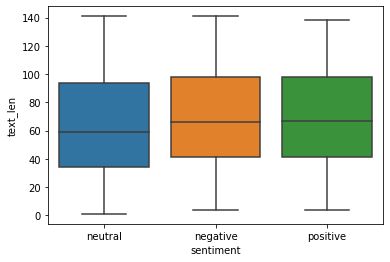

In [77]:
_ = sns.boxplot(x='sentiment', y='text_len', data=train)

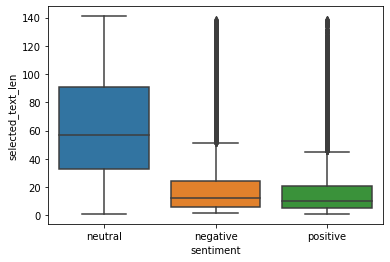

In [78]:
_ = sns.boxplot(x='sentiment', y='selected_text_len', data=train)

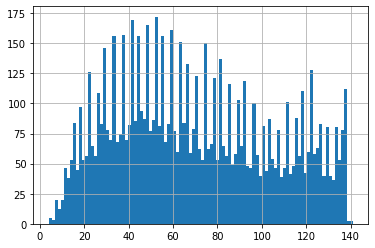

In [82]:
train.loc[train.sentiment=='negative','text_len'].hist(bins=100)

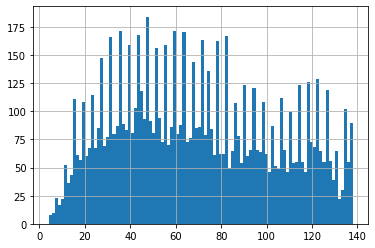

In [83]:
train.loc[train.sentiment=='positive','text_len'].hist(bins=100)

Question 3: How many links are there in text and selected_text

From using excel to search for links:

(seach for http)

1. 1223 rows of text contain a link.
1. 352 row of selected text contain a link.

### for rows with link in text
![rows with links](images/baseline/all_links.png)

### For 352 rows with link in selected text, the class dist is
![neutral rows with links](images/baseline/neutral_links.png)

In [136]:
has_link =  lambda text : 'http' in text

In [138]:
train.text_has_link = train.text.map(has_link)
train.sel_text_has_link = train.selected_text.map(has_link)

In [140]:
train.to_csv('./data/inter/train_v0.csv', index=False) # for analysing with excel

> sentences where link is in text but not in selected text and sentiment is neutral

![peculiar rows with links](images/baseline/peculiar_neutral.png)

## Important points from Data Visualization

1. Remove links when sentiment is positive or negative
1. Keep links when sentiment is neutral


## baseline

In [32]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def average_jaccard(targets, predictions):
    '''get average jaccard for multiple predictions'''
    total_score = 0
    
    for t, p in zip(targets, predictions):
        sample_score = jaccard(t, p)
        total_score += sample_score
    
    return total_score/len(targets)  # average

If we predict the text as the selected_text column

In [150]:
average_jaccard(train.text.values, train.selected_text.values)

0.5890763881111541

## Data Processing



Source : https://www.kaggle.com/vbmokin/tse2020-roberta-cnn-outlier-analysis

In [9]:
MAX_LEN = 96
PATH = '../input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
#     vocab_file=PATH+'vocab-roberta-base.json', 
#     merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)

In [17]:
EPOCHS = 3 # originally 3
BATCH_SIZE = 32 # originally 32
PAD_ID = 1
SEED = 88888
LABEL_SMOOTHING = 0.1
tf.random.set_seed(SEED)
np.random.seed(SEED)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = pd.read_csv('data/train.csv').fillna('')
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [20]:
Dropout_new = 0.125    # originally 0.1
n_split = 5            # originally 5
lr = 3e-5  

In [25]:
def save_weights(model, dst_fn):
    weights = model.get_weights()
    with open(dst_fn, 'wb') as f:
        pickle.dump(weights, f)

def load_weights(model, weight_fn):
    with open(weight_fn, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
    return model

def loss_fn(y_true, y_pred):
    # adjust the targets for sequence bucketing
    ll = tf.shape(y_pred)[1]
    y_true = y_true[:, :ll]
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred,
        from_logits=False, label_smoothing=LABEL_SMOOTHING)
    loss = tf.reduce_mean(loss)
    return loss

def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    padding = tf.cast(tf.equal(ids, PAD_ID), tf.int32)

    lens = MAX_LEN - tf.reduce_sum(padding, -1)
    max_len = tf.reduce_max(lens)
    ids_ = ids[:, :max_len]
    att_ = att[:, :max_len]
    tok_ = tok[:, :max_len]

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids_,attention_mask=att_,token_type_ids=tok_)
    
    x1 = tf.keras.layers.Dropout(Dropout_new)(x[0])
    x1 = tf.keras.layers.Conv1D(768, 2,padding='same')(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Conv1D(64, 2,padding='same')(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(Dropout_new)(x[0]) 
    x2 = tf.keras.layers.Conv1D(768, 2,padding='same')(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Conv1D(64, 2, padding='same')(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr) 
    model.compile(loss=loss_fn, optimizer=optimizer)
    
    # this is required as `model.predict` needs a fixed size!
    x1_padded = tf.pad(x1, [[0, 0], [0, MAX_LEN - max_len]], constant_values=0.)
    x2_padded = tf.pad(x2, [[0, 0], [0, MAX_LEN - max_len]], constant_values=0.)
    
    padded_model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1_padded,x2_padded])
    return model, padded_model

In [27]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [28]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+3] = [0, s_tok] + enc.ids + [2]
    attention_mask[k,:len(enc.ids)+3] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+2] = 1
        end_tokens[k,toks[-1]+2] = 1

In [31]:
input_ids[0]

array([   0, 7974,    2,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1], dtype=int32)

In [26]:
%%time
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start_train = np.zeros((input_ids.shape[0],MAX_LEN))
preds_end_train = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=SEED)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model, padded_model = build_model()
        
    #sv = tf.keras.callbacks.ModelCheckpoint(
    #    '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
    #    save_weights_only=True, mode='auto', save_freq='epoch')
    inpT = [input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]]
    targetT = [start_tokens[idxT,], end_tokens[idxT,]]
    inpV = [input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]]
    targetV = [start_tokens[idxV,], end_tokens[idxV,]]
    # sort the validation data
    shuffleV = np.int32(sorted(range(len(inpV[0])), key=lambda k: (inpV[0][k] == PAD_ID).sum(), reverse=True))
    inpV = [arr[shuffleV] for arr in inpV]
    targetV = [arr[shuffleV] for arr in targetV]
    weight_fn = '%s-roberta-%i.h5'%(VER,fold)
    for epoch in range(1, EPOCHS + 1):
        # sort and shuffle: We add random numbers to not have the same order in each epoch
        shuffleT = np.int32(sorted(range(len(inpT[0])), key=lambda k: (inpT[0][k] == PAD_ID).sum() + np.random.randint(-3, 3), reverse=True))
        # shuffle in batches, otherwise short batches will always come in the beginning of each epoch
        num_batches = math.ceil(len(shuffleT) / BATCH_SIZE)
        batch_inds = np.random.permutation(num_batches)
        shuffleT_ = []
        for batch_ind in batch_inds:
            shuffleT_.append(shuffleT[batch_ind * BATCH_SIZE: (batch_ind + 1) * BATCH_SIZE])
        shuffleT = np.concatenate(shuffleT_)
        # reorder the input data
        inpT = [arr[shuffleT] for arr in inpT]
        targetT = [arr[shuffleT] for arr in targetT]
        model.fit(inpT, targetT, 
            epochs=epoch, initial_epoch=epoch - 1, batch_size=BATCH_SIZE, verbose=DISPLAY, callbacks=[],
            validation_data=(inpV, targetV), shuffle=False)  # don't shuffle in `fit`
        save_weights(model, weight_fn)

    print('Loading model...')
    # model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    load_weights(model, weight_fn)

    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = padded_model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting all Train for Outlier analysis...')
    preds_train = padded_model.predict([input_ids,attention_mask,token_type_ids],verbose=DISPLAY)
    preds_start_train += preds_train[0]/skf.n_splits
    preds_end_train += preds_train[1]/skf.n_splits

    print('Predicting Test...')
    preds = padded_model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-2:b-1])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

NameError: name 'input_ids' is not defined